# import libraries for the experiment

In [4]:
import sys
import os
import json
import random 

import numpy as np                                                                  
import pandas as pd
import matplotlib.pyplot as plt                                                       

import cv2                                                                         
import mediapipe as mp  

from glob import glob                                                               
from pathlib import Path                                                            
from natsort import natsorted                                                       
from tqdm.auto import tqdm 

from sklearn.model_selection import train_test_split                                                
from collections import defaultdict
from typing import Callable, List, Tuple
from numpy.typing import NDArray

import torch
from torch import nn
import torch.optim as optim                                                          
import torch.nn.functional as F 
import seaborn as sns
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
    
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.utils import resample

import captum

from captum.attr import Saliency
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance

In [5]:
sys.path.append(os.path.abspath('../src'))
import prepare_datasets
import preprocess_utils 
import models  
import train_utils 
import plot_utils
import train
import analyse_layer

# Preparing Data

1. Extracting landmarks from the dataset using mediapipe

In [6]:
# define paths (!Note: These paths are based on my computer setup and should be changed based on system file structure!)
# path to the dataset files
# root= 'C:/Users/sadeg/OneDrive/Desktop/Thesis/python_codes/datasets/AUTSL_40/AUTSL_40_videos/' 

# path to where the landdmarks should be saved 
# save_dir= 'C:/Users/sadeg/OneDrive/Desktop/Thesis/python_codes/SignLanguageProject/data/landmarks_autsl40/'  

# get media pipe landmarks
# result= prepare_datasets.get_landmarks(root= root, class_names= prepare_datasets.autslclass_names, frame_numbers= 30)

2. Saving the extracted landmarks and their labels in a directory

In [7]:
# np.save(os.path.join(save_dir, 'detections.npy'), np.array(result[0]))     
# with open(os.path.join(save_dir, 'labels.json'), 'w') as file:
    # json.dump(result[1], file) 

3. Loading all saved landmarks from AUTSL 40 dataset

In [8]:
root_dir= os.path.dirname(os.getcwd())               # defining path to project folder
data_dir= os.path.join(root_dir, 'data')             # path to dataset directories
autsl40= os.path.join(data_dir, 'landmarks_autsl40') # path to WLASL 100 directory

# loading detections and labels for WLASL dataset
autsl40_detections= np.load(os.path.join(autsl40, 'detections.npy'), allow_pickle=True)
with open(os.path.join(autsl40, 'labels.json'), 'r') as file:
     autsl40_labels= json.load(file)

In [9]:
# printing the shape and number of labels to make sure the extraction was successful
print(f"The detection array is of shape: {autsl40_detections.shape} and has {len(autsl40_labels)} labels")

The detection array is of shape: (4947, 30, 1662) and has 4947 labels


# plotting average movements in the dataset

1. **Defining a dictionary** to store all videos belonging to the same label together.

The dictionary will have labels as keys and lists of videos as values. For example:

```python
{
    "Sister": ["video1", "video2", "video3", ...],
    "Hurry":  ["video1", "video2", "video3", ...],
    "Tree":   ["video13", "video2", "video3", ...],
    ...
}

In [19]:
# a dictionary to store videos of same label
data= defaultdict(list)                         
for idx, label in enumerate(autsl40_labels):
    data[label].append(autsl40_detections[idx])

The `for` loop iterates through the dictionary, calculates the **mean movement** for each label and **plots** it as a single MHI image.

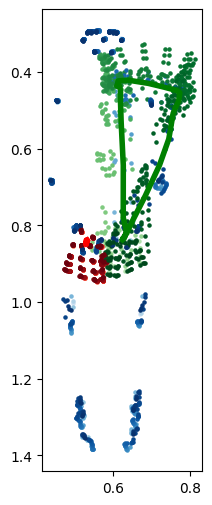

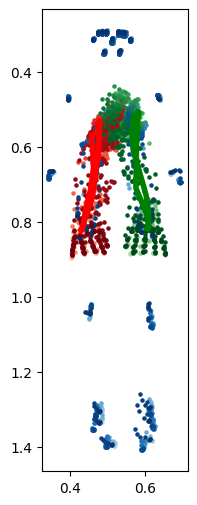

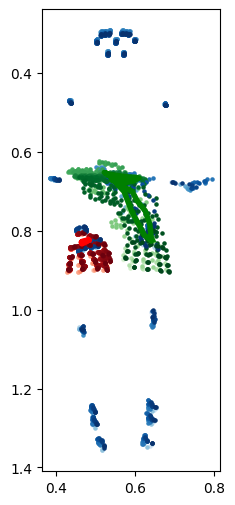

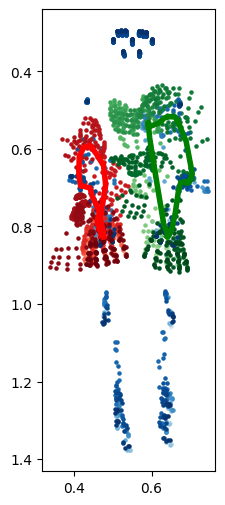

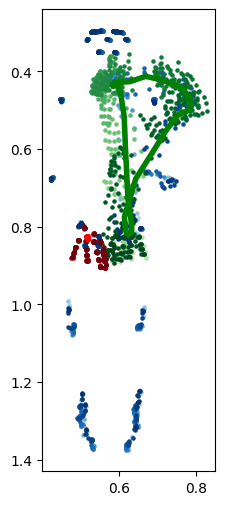

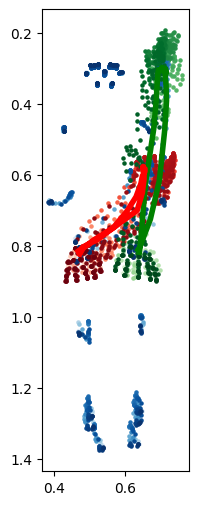

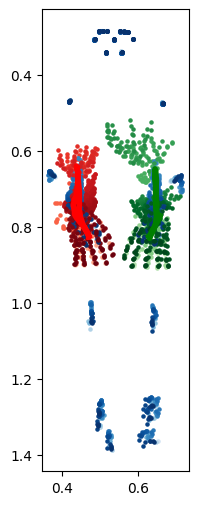

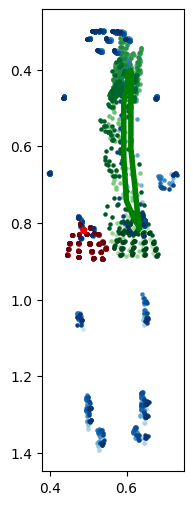

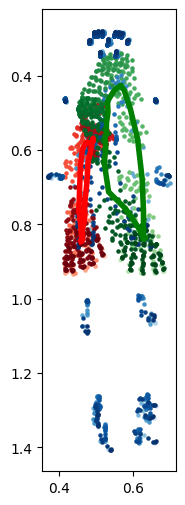

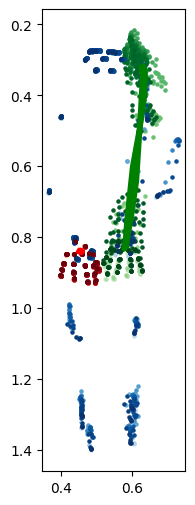

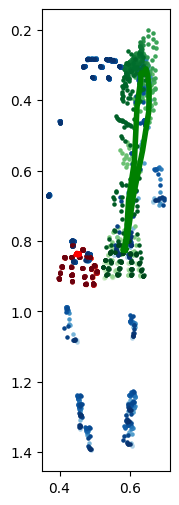

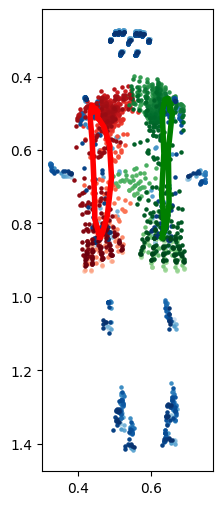

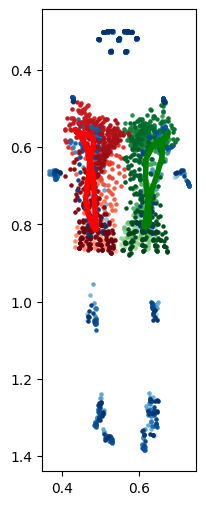

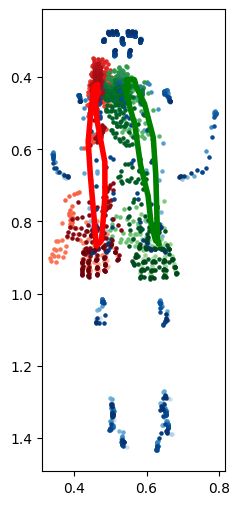

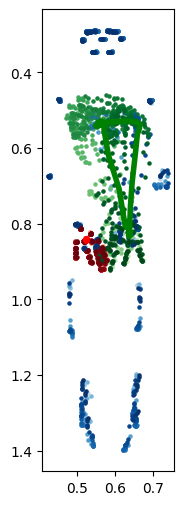

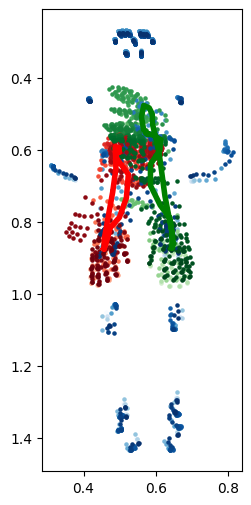

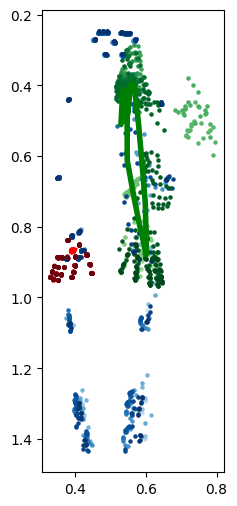

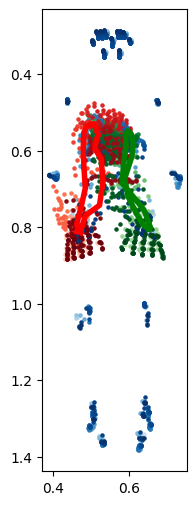

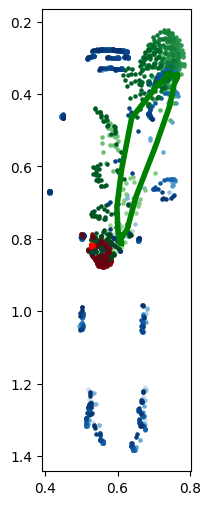

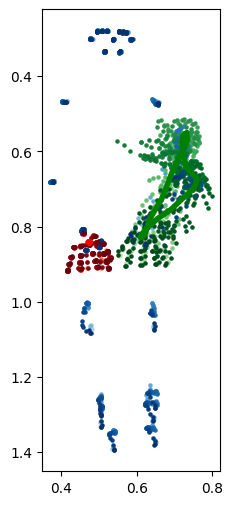

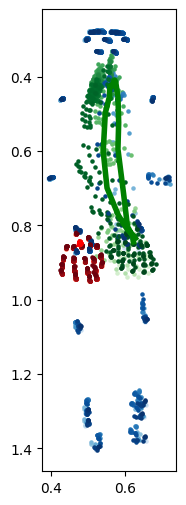

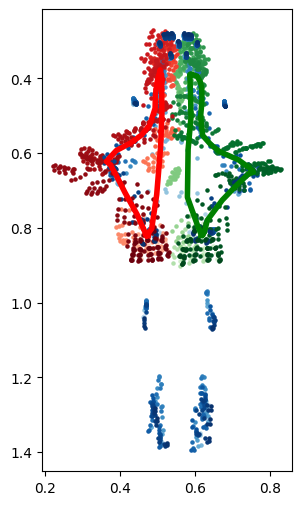

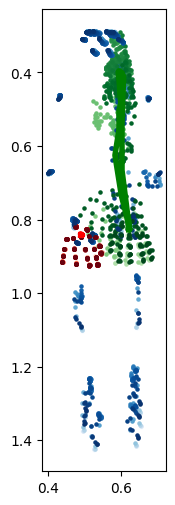

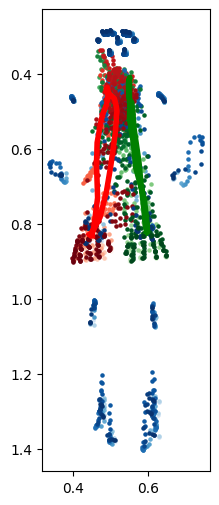

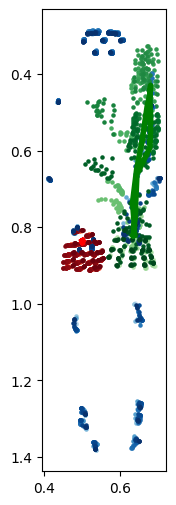

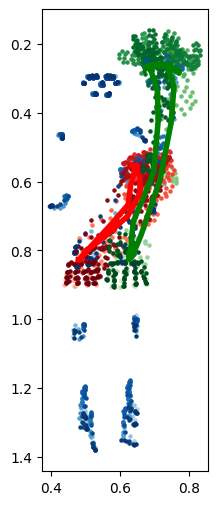

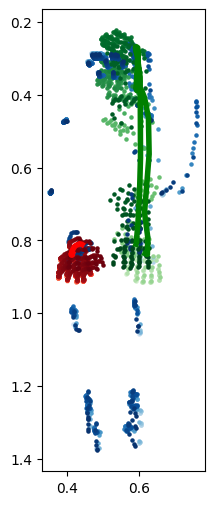

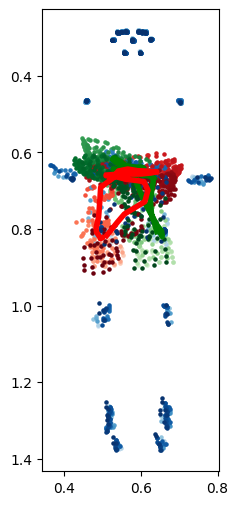

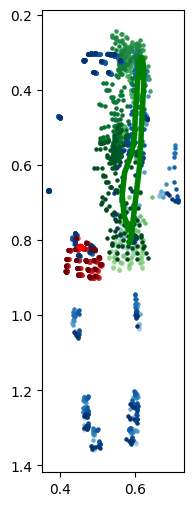

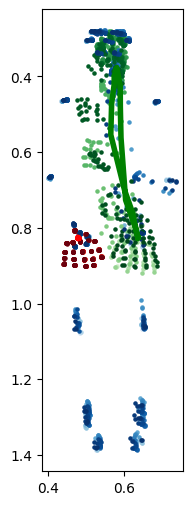

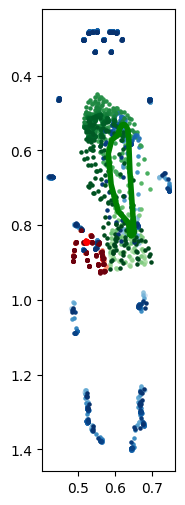

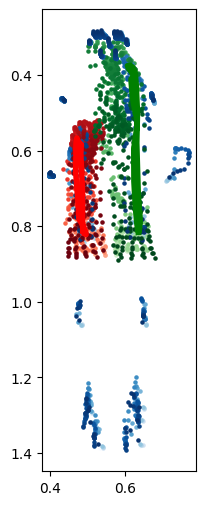

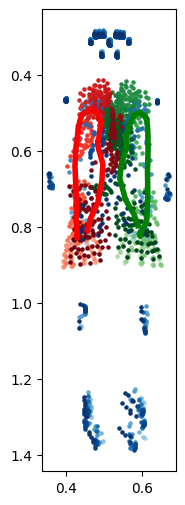

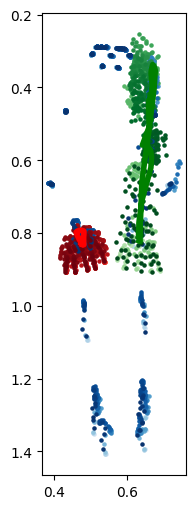

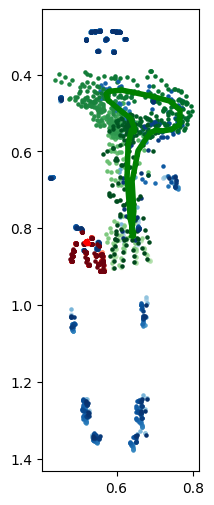

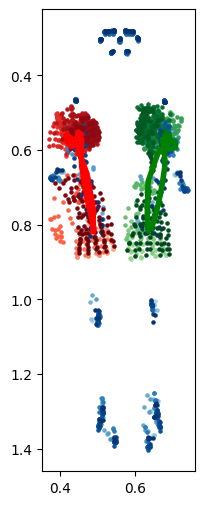

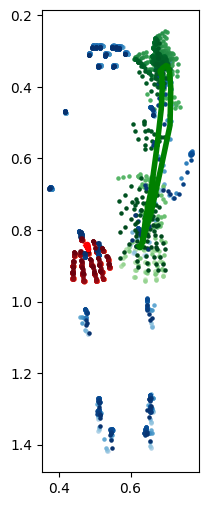

KeyboardInterrupt: 

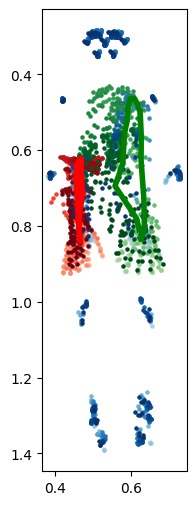

In [20]:
for idx, item in enumerate(data.items()):        # idx is used to save the image at the end.     
    mean_video= item[1][0]                       # select the first video sample of [video1, video2, video3, ..., video n]
    #recursivly update the mean.
    for video_detection in item[1]:
        # calculate mean using linear interpolation
        mean_video= preprocess_utils.interpolate_video_detections(video_detection_1= mean_video,
                                                                  video_detection_2= video_detection,
                                                                  frame_structure= [(0, 132), (132, 1536), (1536, 1599), (1599, 1662)],
                                                                  alpha= 0.5) 
    # plot the average movement for each label and save it using idx variable
    plot_utils.plot_video_detection_as_MHI(video_detection= mean_video, 
                                           num_movements= 30,
                                           height= 512,
                                           width=512,
                                           save_path= f'{idx+1}.png')

In [21]:
mean_video.shape

(30, 1662)

# Preparing the enviroment for training process

1. connecting Cuda

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  #set up device to cuda
print(device)
print(torch.cuda.get_device_name())
print(torch.cuda.get_device_capability())

cuda
NVIDIA GeForce RTX 3060 Laptop GPU
(8, 6)


2. Eliminating face landmarks from the detection arrays

In [15]:
pose = np.arange(0, 132)                                        # indexes of pose landmarks
lh_and_rh = np.arange(1536, 1662)                               # indexes of left hand and right hand landmarks
indices_to_keep = np.concatenate((pose, lh_and_rh))             # concatenate indices to keep
filtered_detections = autsl40_detections[:, :, indices_to_keep] # filter the data to remove face landmarks                                  

In [16]:
# print shape to make sure it is correct
print(f"Shape of the original detections: {autsl40_detections.shape}.\nShape of the filtered detections: {filtered_detections.shape}.")

Shape of the original detections: (4947, 30, 1662).
Shape of the filtered detections: (4947, 30, 258).


3. initializing a transformer architecture

In [17]:
model= models.PETransformer(class_names= prepare_datasets.autslclass_names,
                            seq_len= 30,
                            d_model= 258,
                            nhead= 6,
                            d_ff= 2048,
                            num_layers= 2,
                            dropout=0.1)

4. Training the model on the dataset

Training Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

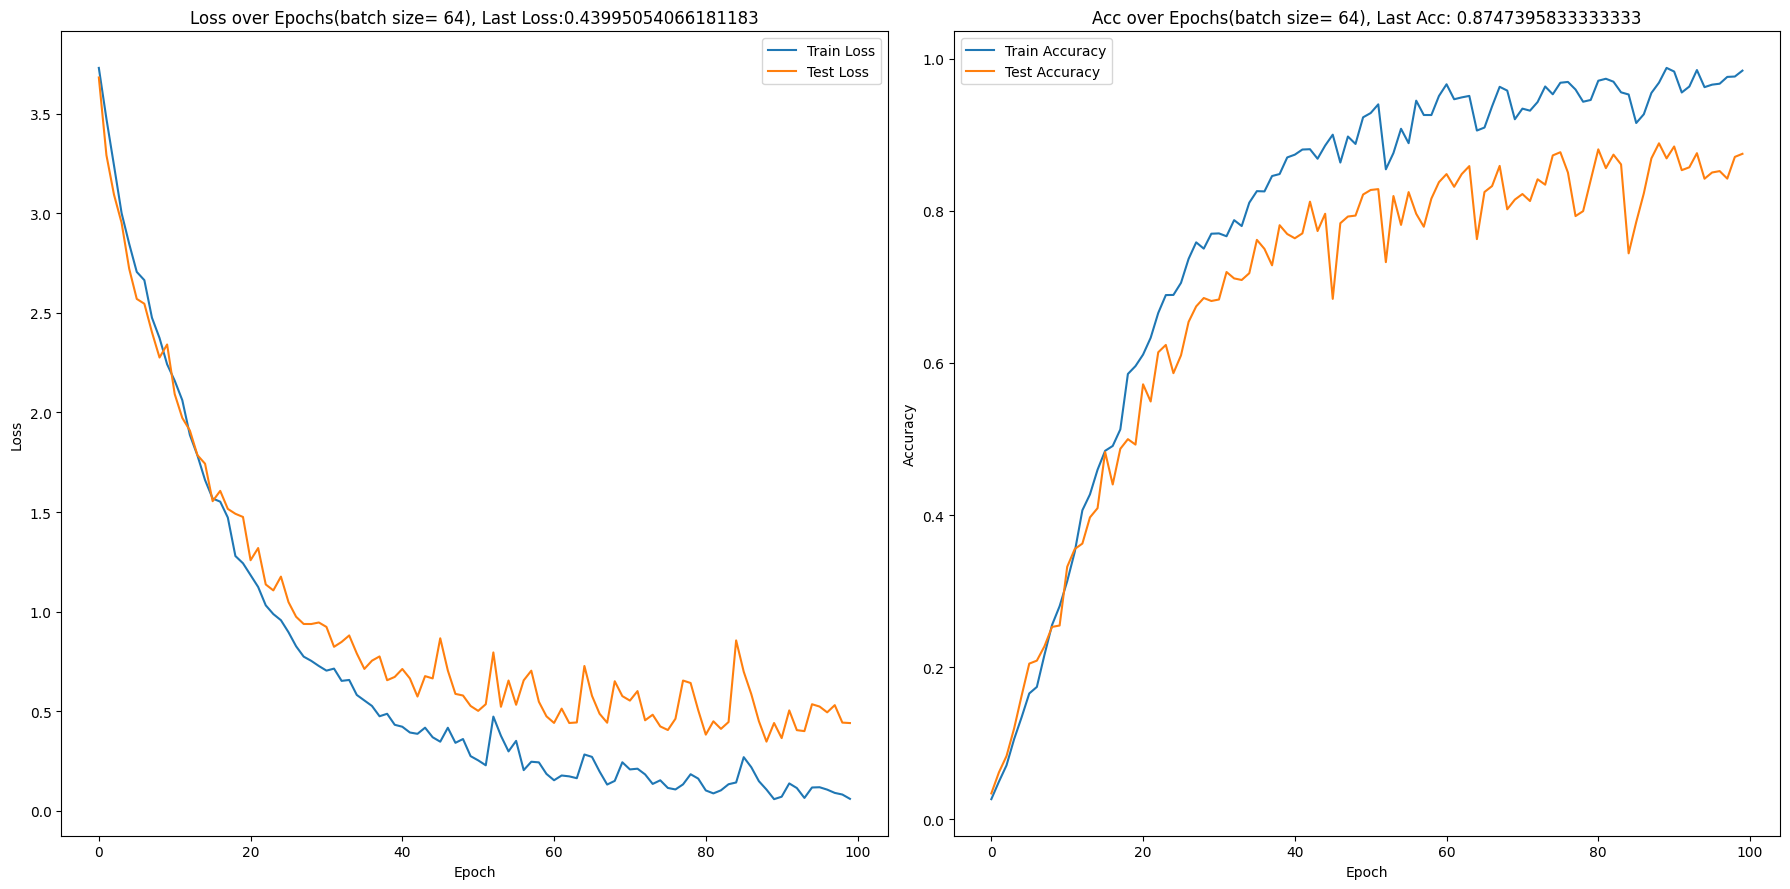

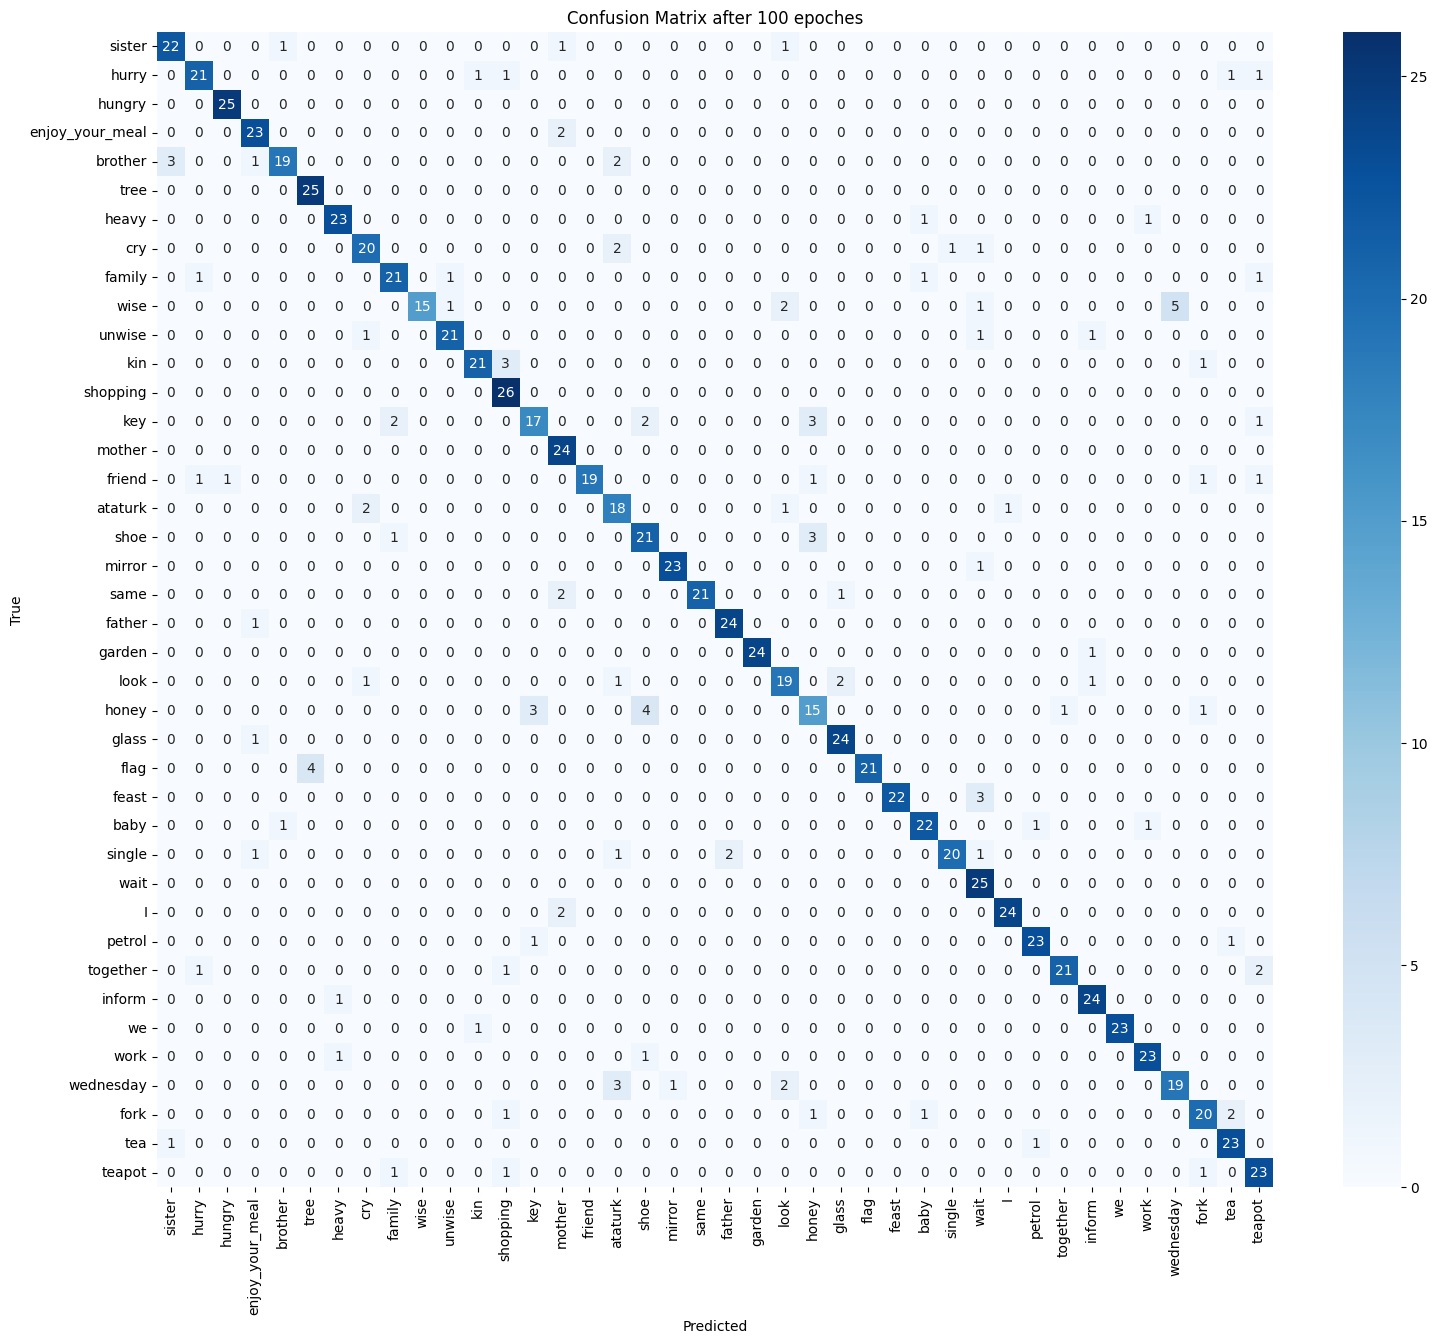

In [18]:
train.configure(detections= filtered_detections,                            # detections
                labels= autsl40_labels,                                     # labels
                class_names= prepare_datasets.autslclass_names,             # classes
                test_size= 0.2,                                             # split size
                batch_size= 64,                                             # batch size
                num_epochs= 100,                                            # number of epoches
                model= model,                                               # model
                lr= 0.0001,                                                 # learning rate
                device= device,                                             # device for training
                quick_save= False,                                          # save the plots or not
                results_name= '30fps_b_64_nl_2_nh_6_dff_2048',               # name of the file in tensorboard: we write something informatic
                dataset_name= 'AUTSL40')                                    # to determine under which dataset folder the tensorboard file is saved.

# Using Saliency

1. prepare the data

In [24]:
# converting detections and labels to the right format again
X, y= preprocess_utils.convert(detections= filtered_detections, labels= autsl40_labels, class_names= prepare_datasets.autslclass_names) 
# making a datast object
dataset = train.CustomDataset(X, y)
# choosing one sample
video_detection_sample, label_sample= dataset[3]

***Note:***: Although the dataset is **shuffled during training**, the dataset object created above is **ordered by label**. * The dataset object is structured as follows:
- `video1, label1`, `video2, label1`, `video3, label1`, ..., `videon, label1`
- `video1, label2`, `video2, label2`, `video3, label2`, ..., `videon, label2`
- And so on for each labl...


2. define `Saliency` object

In [25]:
# defining saliency object
sailency= Saliency(forward_func= model)

In [26]:
video_detection_sample, label_sample = video_detection_sample.to(device), label_sample.to(device)    # put on GPU
video_detection_sample= video_detection_sample.unsqueeze(0)                        
video_detection_sample.requires_grad_()

attributions= sailency.attribute(inputs= video_detection_sample, target= label_sample.item())

In [27]:
attributions

tensor([[[0.0232, 0.0524, 0.0041,  ..., 0.0201, 0.0124, 0.0361],
         [0.0233, 0.0538, 0.0116,  ..., 0.0206, 0.0090, 0.0339],
         [0.0236, 0.0479, 0.0157,  ..., 0.0193, 0.0045, 0.0326],
         ...,
         [0.0364, 0.0549, 0.0134,  ..., 0.0125, 0.0116, 0.0330],
         [0.0327, 0.0519, 0.0116,  ..., 0.0182, 0.0037, 0.0324],
         [0.0285, 0.0491, 0.0136,  ..., 0.0178, 0.0043, 0.0339]]],
       device='cuda:0')

Calculating attribution scores for a video sample

In [ ]:
# calculating attribution scores for the video sample
lm_attributions= analyse_layer.landmark_attributions(model= model,
                                                     captum_method= sailency,
                                                     video_detection= video_detection_sample,
                                                     label= label_sample,
                                                     device= device)
# plotting the attribution scors
analyse_layer.plot_atts_heatmap(attributions= lm_attributions,
                                save_path= 'transformer_trained_label_0.png',
                                show_landmark_names= True)

***Calculating average attribution score for the entire dataset***

In [ ]:
lm_atts_dataset= analyse_layer.landmark_attributions_for_dataset(model= model,
                                                                 captum_method= sailency,
                                                                 dataset= dataset,
                                                                 device= device)
# plotting the attribution scors
analyse_layer.plot_atts_heatmap(attributions= lm_atts_dataset,
                                save_path= 'transformer_trained_over_dataset.png', 
                                show_landmark_names= True)

***Calculating attribution scores across calsses of the dataset***

1. Define a dictionary to store all indexes of samples that belong to the same label.
The dictionary has the following structure:

- The labels have been converted to numbers. Each **label** is a key, and the corresponding value is a list of indices representing the videos for that label. The length of the list may vary, as different labels can have a different number of videos.

Example:

```python
{
    "0": [0, 1, 2, ..., n],
    "1": [0, 1, 2, 3, ..., m],
    ...
}

In [21]:
# dictionary to store the list of indexes of samples that belong to same labels  
word_positions = defaultdict(list)              
for i, (x, y) in enumerate(dataset):        
    word_positions[y.item()].append(i)              

2. For all videos under the same label, we calculate the average attribution scores and plot it.

In [ ]:
for i in range(len(prepare_datasets.autslclass_names)):                          # for all classes in the dataset
    subset_dataset = Subset(dataset, word_positions[i])                          # subset is all indexes that belongs to that class 
    # calculating average attribution scores for the subset
    lm_atts_word = analyse_layer.landmark_attributions_for_dataset(model= model,
                                                                   captum_method= sailency,
                                                                   dataset= subset_dataset,
                                                                   device= device)
    #plotting the results
    analyse_layer.plot_atts_heatmap(attributions= lm_atts_word, save_path= f'{i+1}.png', show_landmark_names= True)

***Comparing saliency maps with untrained model***

1. define the same model that was trained

In [19]:
new_model= models.ParamTransformer(class_names= prepare_datasets.autslclass_names,
                                   seq_len= 30,
                                   d_model= 258,
                                   nhead= 6,
                                   d_ff= 2048,
                                   num_layers= 2,
                                   dropout=0.1)

2. Define new `Saliency` object

In [20]:
new_sailency= Saliency(forward_func= new_model)

Calculating landmark attributions for the sample video

In [ ]:
lm_attributions= analyse_layer.landmark_attributions(model= new_model,
                                                     captum_method= new_sailency,
                                                     video_detection= video_detection,
                                                     label= label,
                                                     device= device)

analyse_layer.plot_atts_heatmap(attributions= lm_attributions, save_path= 'transformer_untrained_label_0.png', show_landmark_names= True, vmin= 0.0, vmax= 0.25)

***Calculating landmark attributions for the entire dataset***

In [ ]:
lm_atts_dataset= analyse_layer.landmark_attributions_for_dataset(model= new_model,
                                                                 captum_method= new_sailency,
                                                                 dataset= dataset,
                                                                 device= device)

analyse_layer.plot_atts_heatmap(attributions= lm_atts_dataset, save_path= 'transformer_untrained_over_dataset.png', show_landmark_names= True, vmin= 0, vmax= 0.25)

# Plotting Saliency attribution scores on a video

1. define video path

In [63]:
video_path= "C:/Users/sadeg/OneDrive/Desktop/Thesis/python_codes/datasets/AUTSL_40/AUTSL_40_videos/0/signer0_sample1034_color.mp4"

2. plot the attribution scores on the video

In [67]:
analyse_layer.plot_attributions_on_video(video_path= video_path,
                                         model= model,
                                         captum_method= sailency,
                                         class_names= prepare_datasets.autslclass_names,
                                         device= device, 
                                         frame_numbers= 30)

Calculating landmark attributions for the sign language video sister


# Kfold Cross validation:

1. define model configuration

In [44]:
model_args = {'class_names': prepare_datasets.autslclass_names,
              'seq_len': 30,
              'd_model': 258,              
              'nhead': 6, 
              'd_ff': 512,                
              'num_layers': 2, 
              'dropout': 0.1}

2. Training the model on the dataset using cross validation

In [ ]:
train.configure_Kfold(detections= filtered_detections,                             # detections
                      labels= autsl40_labels,                                      # labels
                      class_names= prepare_datasets.autslcl ass_names,             # classes
                      n_splits= 5,                                                 # number of splits or folds
                      batch_size= 64,                                              # batch size
                      num_epochs= 100,                                             # number of epochs
                      model_class= models.PETransformer,                           # class of the model
                      model_args= model_args,                                      # model configuration
                      lr= 0.0001,                                                  # learning rate
                      device= device,                                              # processing device
                      quick_save= False)                                           # save the results in the current dictionary?

***Note:*** Below is a cell that executes **K-Fold Cross Validation**. It was used to modify parameters more easily without having to change the `configure_kfold` function and save the `train.py` file every time.


In [ ]:
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold

# Paths
experiment_dir = "C:/Users/sadeg/OneDrive/Desktop/Thesis/python_codes/SignLanguageProject/experiment_results"  # tensorboard results directory
dataset_name = "AUTSL"         # folder
results_name = "Kfoldexample"  # file name

# Parameters
kf = KFold(n_splits=5, shuffle=True)    # kfold object
batch_size = 64   #batch size
num_epochs = 100  # epoch

# Store overall results for K-Fold
k_fold_accuracies = []
k_fold_losses = []

# Iterate based on number of folds
for fold, (train_index, test_index) in enumerate(kf.split(autsl40_detections)):
    print(f"\n=== Processing Fold {fold + 1} ===")

    # splitting dataset to train and test ; 4 train folds and 1 test fold
    x_train, x_test = autsl40_detections[train_index], autsl40_detections[test_index]
    y_train, y_test = np.array(autsl40_labels)[train_index].tolist(), np.array(autsl40_labels)[test_index].tolist()
    # print(x_train.shape, len(y_train), x_test.shape, len(y_test))

    # eliminate head landmarks
    pose = np.arange(0, 132)
    lh_and_rh = np.arange(1536, 1662)
    indices_to_keep = np.concatenate((pose, lh_and_rh))
    x_train = x_train[:, :, indices_to_keep]       # Filter out head landmarks from xtrain
    x_test = x_test[:, :, indices_to_keep]         # Filter out head landmarks from xtest

    # print(x_train.shape, len(y_train), x_test.shape, len(y_test))

    # Convert x_train, y_train and x_test, y_test to the correct format for training
    x_train, y_train = preprocess_utils.convert(x_train, y_train, prepare_datasets.autslclass_names)
    x_test, y_test = preprocess_utils.convert(x_test, y_test, prepare_datasets.autslclass_names)

    #print(type(x_train), type(y_train), type(x_test), type(y_test))

    # creating datasets and dataloaders for training and testing
    train_dataset = train.CustomDataset(x_train, y_train)
    test_dataset = train.CustomDataset(x_test, y_test)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=0, shuffle=False)

    # Initialize the model for this fold
    model = models.PETransformer(class_names=prepare_datasets.autslclass_names,
                                 seq_len=30,
                                 d_model=258,
                                 nhead= 6,
                                 d_ff= 2048,
                                 num_layers=2,
                                 dropout= 0.1)
    # send model to device
    model = model.to(device)

    # define loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Directory for saving results specific to this fold
    fold_dir = f'{experiment_dir}/{dataset_name}/{model.model_type}/runs/{results_name}/fold_{fold + 1}'

    # lists to store accuracy and loss for each epoch in this fold
    epoch_accuracies = []
    epoch_losses = []

    # train the model for this fold
    train_l, test_l, train_a, test_a, y_trues, y_preds = train_utils.train_model(num_epochs,
                                                                                 model,
                                                                                 train_loader,
                                                                                 test_loader,
                                                                                 optimizer,
                                                                                 loss_fn,
                                                                                 device)
    # Store losses and accuracies for each epoch in this fold
    epoch_accuracies.extend(test_a)
    epoch_losses.extend(test_l)
    
    # plot results for this fold
    plot_utils.plot_loss_accuracy(train_l, test_l, train_a, test_a, batch_size, f'4loss_acc_fold_{fold + 1}.png')
    #plot_utils.plot_confusion_matrix(y_trues, y_preds, prepare_datasets.autslclass_names, num_epochs, f'confmat_fold_{fold + 1}.png')
    #plot_utils.draw_in_tensorboard(train_l, test_l, train_a, test_a, fold_dir)
    
    # Store final accuracy and loss for the fold
    final_accuracy = test_a[-1]                             #the last epoch's test accuracy
    final_loss = test_l[-1]                                 #the last epoch's test loss
    print(f"\n=== Fold {fold + 1} Results ===")
    print(f"Fold {fold + 1} Final Accuracy: {final_accuracy:.4f}")
    print(f"Fold {fold + 1} Final Loss: {final_loss:.4f}")
    
    k_fold_accuracies.append(final_accuracy)    # store the final test accuracy
    k_fold_losses.append(final_loss)            # store the final test loss

    print(f"Completed Fold {fold + 1}")


# Calculate K-Fold metrics
min_accuracy = np.min(k_fold_accuracies)     # minimum accuracy of the experiment
max_accuracy = np.max(k_fold_accuracies)     # maximum accuracy of the experiment
mean_accuracy = np.mean(k_fold_accuracies)   # average accuracy of the experiment
std_accuracy = np.std(k_fold_accuracies)     # standard deviation of final test accuracies of the experiment
mean_loss= np.mean(k_fold_losses)            # average loss of the experiment

# Print K-Fold summary
print("\n=== K-Fold Summary ===")
print(f"Min Accuracy: {min_accuracy:.4f}")
print(f"Max Accuracy: {max_accuracy:.4f}")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation (Accuracy): {std_accuracy:.4f}\n")
print(f"mean loss: {mean_loss:.4f}")

# unrelated stuff...

In [3]:
video_path= "C:/Users/sadeg/OneDrive/Desktop/Thesis/python_codes/datasets/AUTSL_40/AUTSL_40_videos/0/signer0_sample1034_color.mp4"
video_path2= "C:/Users/sadeg/OneDrive/Desktop/Thesis/python_codes/datasets/WLASLdataset_100/thankyou.mp4"

In [6]:
analyse_layer.plot_mediapipe_drawing_on_video(video_path= video_path, frame_numbers= 60)

In [10]:
pose = np.arange(0, 132)                                        # indexes of pose landmarks
lh_and_rh = np.arange(1536, 1662)                               # indexes of left hand and right hand landmarks
indices_to_keep = np.concatenate((pose, lh_and_rh))             # concatenate indices to keep
filtered_detections = autsl40_detections[:, :, indices_to_keep] # filter the data to remove face landmarks 

In [25]:
plot_utils.show_video_detections(video_detection= filtered_detections[2266], frame_structure= [(0, 132), (132, 1536), (1536, 1599), (1599, 1662)],
                                height= 512, width= 512)

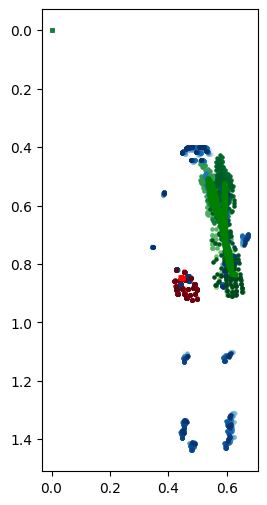

In [22]:
plot_utils.plot_video_detection_as_MHI(autsl40_detections[3], 30, 512, 512)

In [ ]:
import mediapipe as mp
import cv2

In [2]:
with mp.solutions.holistic.Holistic(min_detection_confidence= 0.5, min_tracking_confidence=0.5) as holistic:
    video_path2= "C:/Users/sadeg/OneDrive/Desktop/Thesis/python_codes/datasets/WLASLdataset_100/thankyou.mp4"
    frame_numbers= 30
    cap = cv2.VideoCapture(video_path)                             # capture each video using OpenCV
    if not cap.isOpened():                                         # if OpenCV can't capture the video path
        none_cv2_video_paths.append(video_path)                    # add the video path to none_cv2_video_paths
    else:                                                                                                      
        video_detections= []                                                                     # a list to store video detections
        total_frames_number= cap.get(cv2.CAP_PROP_FRAME_COUNT)                                   # getting total number of frames from a video
        total_frames_number = int(total_frames_number)                                           # changing float to integer   
        frame_idxs_to_process = np.linspace(0, total_frames_number-1, frame_numbers, dtype=int)  # picking desiered frame indexes    
        for idx in frame_idxs_to_process:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)                             # set the video to the desired frame index
            ret, frame= cap.read()                                            # reading the frame 
            result= holistic.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  # processing the frame (Mediapipe works with RGB)
            pose,face,lh, rh= get_frame_detections(result)                    # turning results into flattened arrays
            frame_detection= np.concatenate((pose,face,lh, rh))  
            video_detections.append(frame_detection)                          # storing the frame detection in the video detection list
                    
            cap.release()

NameError: name 'mp' is not defined